<a href="https://colab.research.google.com/github/myconcordia/A2I2/blob/main/Darts_AirQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Darts**
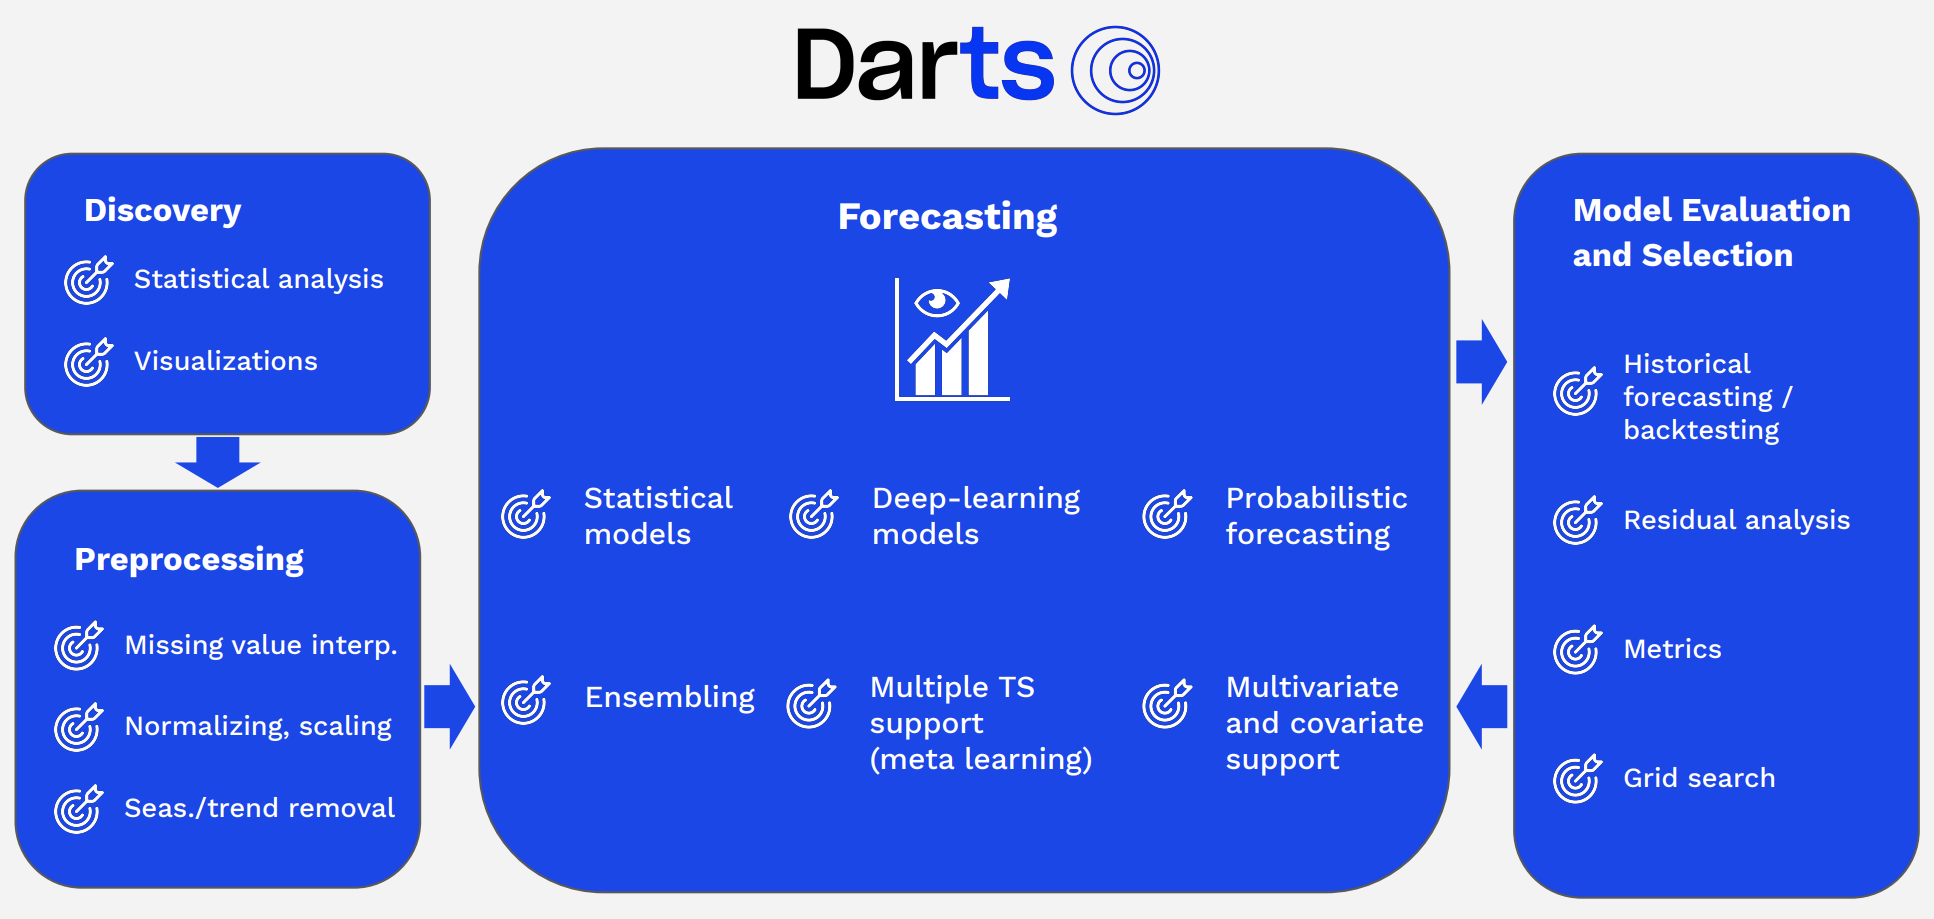

In [1]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.9/846.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 

**Import Libraries**

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
plt.rcParams['figure.figsize'] = (7,5)

import torch
from darts.metrics import mape, smape, mae, rmse
from darts import TimeSeries

from darts.utils.callbacks import TFMProgressBar

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

**Dataset**

In [3]:
#read csv file into dataframe
data_url = 'https://raw.githubusercontent.com/myconcordia/A2I2/main/Air_Quality.csv'
df = pd.read_csv(data_url)
df.info(memory_usage='deep')
cm = sns.light_palette("gray", as_cmap=True)
df.head(10).style.background_gradient(cmap='Blues')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    153 non-null    object 
 1   Ozone   116 non-null    float64
 2   Solar   146 non-null    float64
 3   Wind    153 non-null    float64
 4   Temp    153 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 14.9 KB


,Date,Ozone,Solar,Wind,Temp
0,1976-05-01,41.000000,190.000000,7.400000,67
1,1976-05-02,36.000000,118.000000,8.000000,72
2,1976-05-03,12.000000,149.000000,12.600000,74
3,1976-05-04,18.000000,313.000000,11.500000,62
4,1976-05-05,nan,nan,14.300000,56
5,1976-05-06,28.000000,nan,14.900000,66
6,1976-05-07,23.000000,299.000000,8.600000,65
7,1976-05-08,19.000000,99.000000,13.800000,59
8,1976-05-09,8.000000,19.000000,20.100000,61
9,1976-05-10,nan,194.000000,8.600000,69


**Optimize your Pandas data frame's memory footprint**

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    153 non-null    datetime64[ns]
 1   Ozone   116 non-null    float64       
 2   Solar   146 non-null    float64       
 3   Wind    153 non-null    float64       
 4   Temp    153 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 6.1 KB


In [ ]:
#df['Ozone'] = df['Ozone'].astype('int64')  #gives errors because of NaNs
df['Ozone'] = df['Ozone'].astype('float16')
df['Solar'] = df['Solar'].astype('float16')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    153 non-null    datetime64[ns]
 1   Ozone   116 non-null    float16       
 2   Solar   146 non-null    float16       
 3   Wind    153 non-null    float64       
 4   Temp    153 non-null    int64         
dtypes: datetime64[ns](1), float16(2), float64(1), int64(1)
memory usage: 4.3 KB


# **Exploratory Data Analysis**

In [ ]:
#Install Plotly, an interactive library
!pip install plotly --quiet

**Initial analysis**

In [ ]:
df.columns

Index(['Date', 'Ozone', 'Solar', 'Wind', 'Temp'], dtype='object')

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,153,1976-07-16 00:00:00,1976-05-01 00:00:00,1976-06-08 00:00:00,1976-07-16 00:00:00,1976-08-23 00:00:00,1976-09-30 00:00:00,NaN
Ozone,116.0,42.125,1.0,18.0,31.5,63.25,168.0,33.0
Solar,146.0,186.0,7.0,115.75,205.0,258.75,334.0,90.0625
Wind,153.0,9.957516,1.7,7.4,9.7,11.5,20.7,3.523001
Temp,153.0,77.882353,56.0,72.0,79.0,85.0,97.0,9.46527


In [ ]:
import plotly.graph_objects as go

# List of columns to plot
columns_to_plot = ['Ozone', 'Solar', 'Wind', 'Temp']

# Iterate through each column and plot
for column in columns_to_plot:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df[column], mode='lines', name=column))
    fig.update_layout(title=f'{column} Time Series', xaxis_title='Date', yaxis_title='Value')
    fig.show()

**Checking for missing values**

In [ ]:
# find the number of missing values in each column
print("Number of missing values in each column:")
df.isnull().sum()

Number of missing values in each column:


Date      0
Ozone    37
Solar     7
Wind      0
Temp      0
dtype: int64

In [ ]:
# Calculate the percentage of missing values in each column
missing_percentages = (df.isnull().sum() / len(df)) * 100

# Create a bar chart
fig = go.Figure(data=[go.Bar(
    x=missing_percentages.index,
    y=missing_percentages.values,
    marker_color='lightsalmon'  # Adjust the color as needed
)])

# Update layout
fig.update_layout(
    title='Percentage of Missing Values in Each Column',
    xaxis_title='Columns',
    yaxis_title='Percentage Missing (%)'
)

# Show the plot
fig.show()

**Analysis of Missing Data by Visualization**

<Axes: >

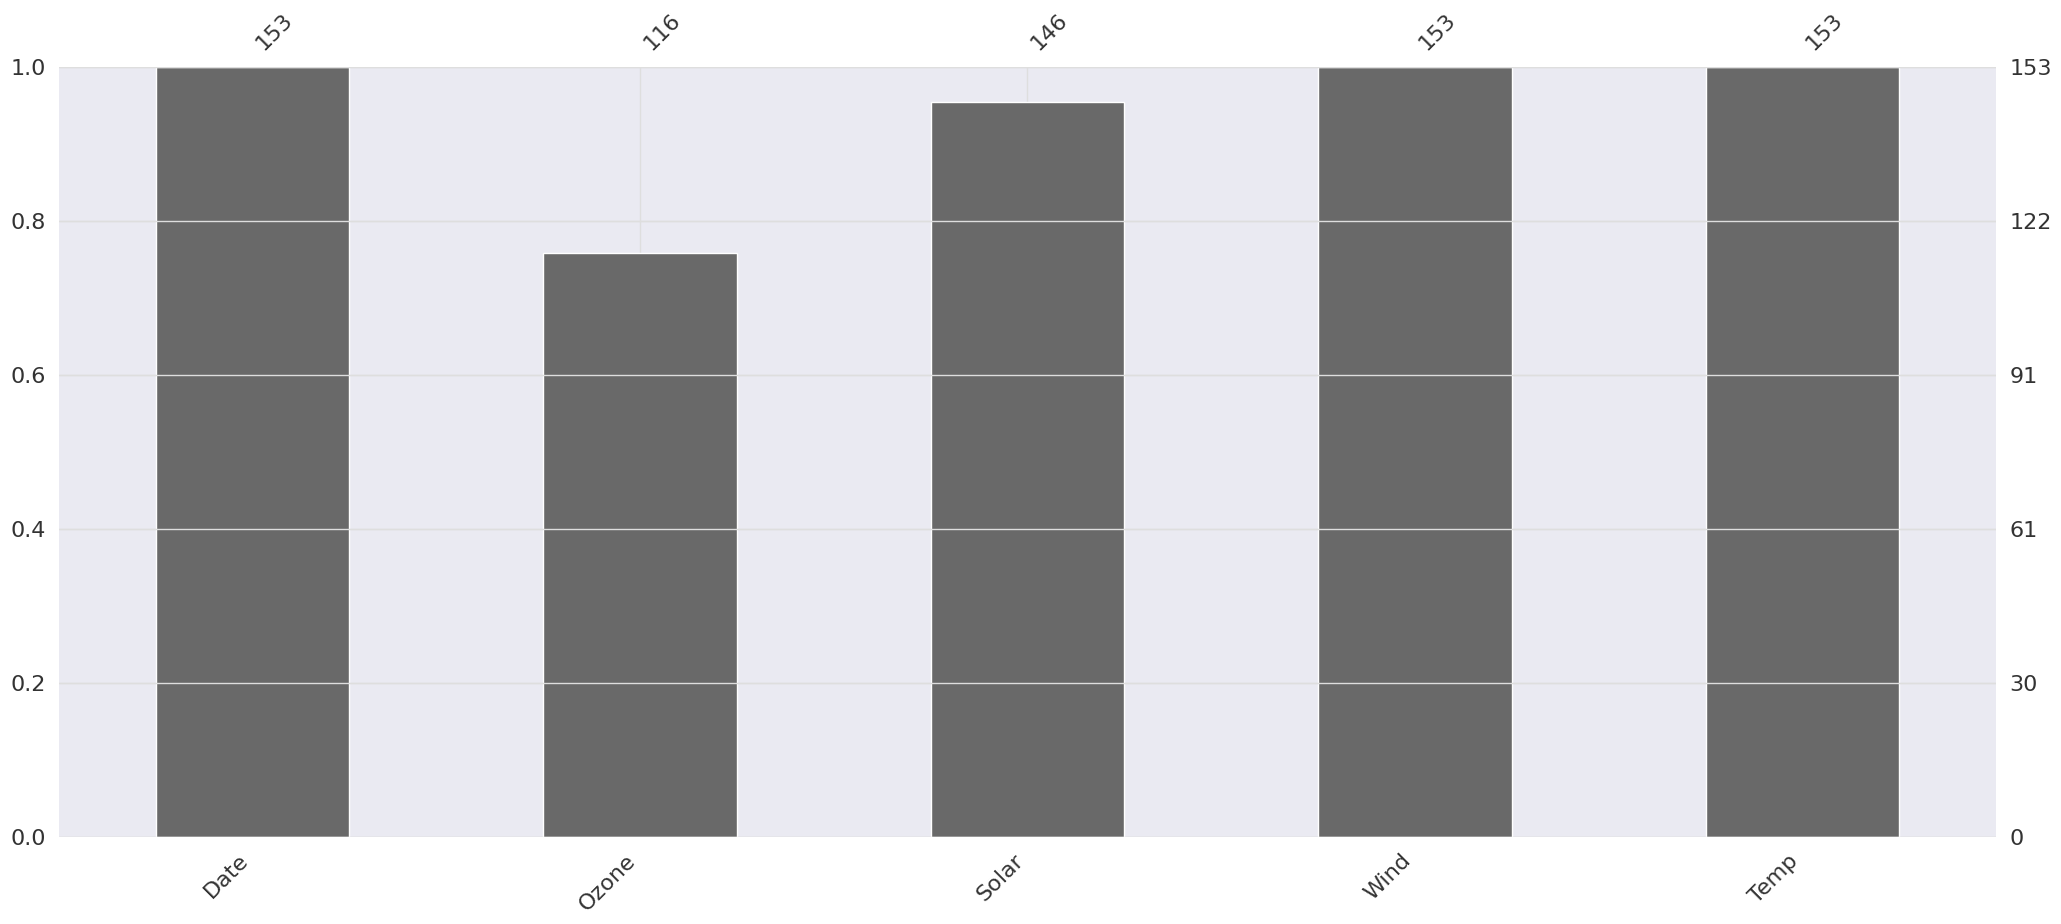

In [ ]:
# Import missingno as msno
import missingno as msno
# Plot amount of missingness (visualization of nullity by column)
msno.bar(df)

The above plot shows whether there are any missing values present in the dataset in either of the columns. It shows the index or position of the missing entries.

<Axes: >

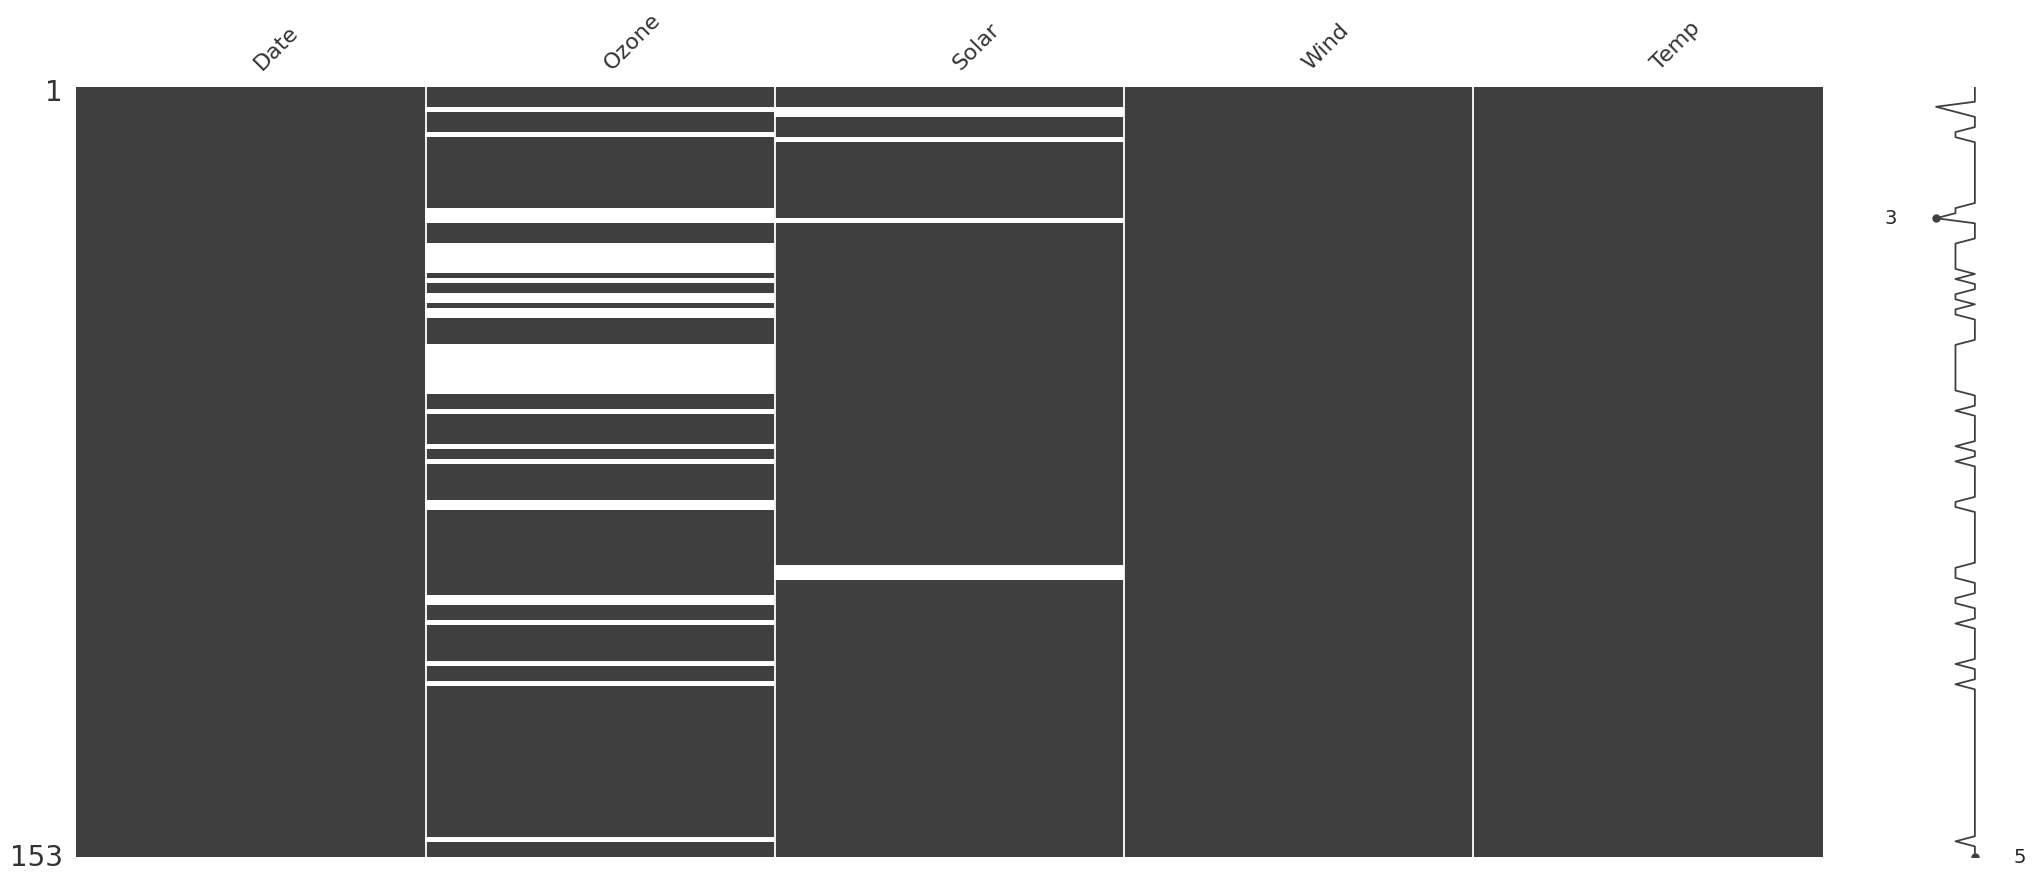

In [ ]:
msno.matrix(df)

The bars with white rows indicate missing values. The sparkline on the right right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

**Checking for Duplicates Values**

It's also necessary to check for any duplicate entries in the dataset. The duplicate entries will cause redundency so it's better to remove duplicates from the dataset.

In [ ]:
# Identify duplicate rows
duplicates = df[df.duplicated(keep=False)]

# Print the duplicate rows
if len(duplicates) > 0:
    print('Duplicate Rows:')
    print(duplicates)
else:
    print('No duplicates found.')

print("Total Duplicate Entries: ", len(duplicates))

No duplicates found.
Total Duplicate Entries:  0


In [ ]:
## Remove duplicate rows
#df = df.drop_duplicates()

**Normality Check**

We can also check the distribution of different features as well as perform normality check to understand whether the features are normally distributed or not.

array([[<Axes: title={'center': 'Ozone'}>,
        <Axes: title={'center': 'Solar'}>],
       [<Axes: title={'center': 'Wind'}>,
        <Axes: title={'center': 'Temp'}>]], dtype=object)

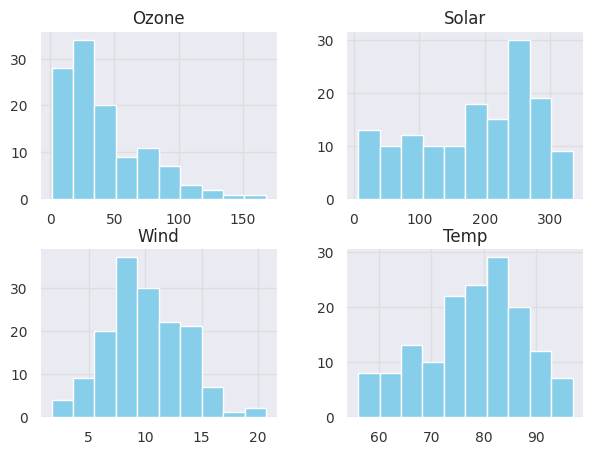

In [ ]:
df.hist(column = ['Ozone', 'Solar', 'Wind', 'Temp'], color = "skyblue")

It seems like the wind and temperature are normally distributed. The other variables are not normally distributed (some sort of skewness is present).

**Checking correlation among variables**

Checking correlation among features involves examining the extent to which the different independent variables in a dataset are related to each other. Correlation is a statistical measure that quantifies the degree of association between two variables, and it ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

When building a predictive model, it is important to check for correlation among the independent variables because highly correlated variables can lead to problems such as multicollinearity, which can affect the stability and reliability of the model's coefficients. Multicollinearity occurs when two or more independent variables in a regression model are highly correlated, making it difficult to determine the individual effect of each variable on the dependent variable

In [ ]:
import plotly.express as px

# Filter numerical columns
numerical_data = df.select_dtypes(include='number')

# Create correlation matrix and round the values to 2 decimals
corr = numerical_data.corr().round(2)

# Create heatmap using Plotly
px.imshow(corr, color_continuous_scale='RdBu', text_auto=True, aspect="auto",
          labels=dict(x='Variables', y='Variables', color='Correlation'),
                width=550, height=500)

From the above plot, we can see that the variables are not highly correlated (except perhaps, Ozone and Temp). If independent variables are correlated with each other, then it results in a multicollinearity issue.

**Checking Outliers**

Outliers are data points that significantly deviate from the majority of the observations in a dataset. They are observations that are unusually distant from other data points and may indicate errors, anomalies, or special circumstances within the data. So, it is necessary to check the presence of outliers in different features.

In [ ]:
px.box(pd.melt(df), x="variable", y="value", width=700)

From the above plot, we can see the presence of outliers. So, we need to perform standard scaling to handle these outliers.

**How to select certain columns**

In [ ]:
dfc = pd.read_csv(data_url, usecols=['Date', 'Ozone', 'Temp'])
dfc.info(memory_usage='deep')
dfc.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    153 non-null    object 
 1   Ozone   116 non-null    float64
 2   Temp    153 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 12.5 KB


,Date,Ozone,Temp
0,1976-05-01,41.0,67
1,1976-05-02,36.0,72
2,1976-05-03,12.0,74
3,1976-05-04,18.0,62
4,1976-05-05,NaN,56
5,1976-05-06,28.0,66
6,1976-05-07,23.0,65
7,1976-05-08,19.0,59
8,1976-05-09,8.0,61
9,1976-05-10,NaN,69


In [ ]:
#Add NaNs to Ozone every five reads
#dfc.loc[::5, 'Ozone'] = np.nan
#dfc.head(7)

**Interpolation (fill missing values)**

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate


The **df.interpolate()** method in pandas offers several interpolation methods to fill missing values in a DataFrame or Series. Here's an explanation of the various methods available:

**linear** (default): This method performs linear interpolation, which fills missing values with a linearly interpolated value based on the surrounding non-missing values. It calculates the missing values by drawing a straight line between the two nearest non-missing values.

**time**: If the index of the DataFrame or Series is datetime-like, the time method performs interpolation based on time. It works similarly to linear interpolation but considers the time intervals between data points when interpolating missing values.

**index**: This method is similar to the time method but doesn't require the index to be datetime-like. It interpolates based on the index values of the DataFrame or Series.

**values**: The values method fills missing values by considering the numeric values in the DataFrame or Series without considering the index. It performs linear interpolation based solely on the position of the missing values within the dataset.

**polynomial**: This method performs polynomial interpolation to fill missing values. It fits a polynomial curve to the data points surrounding the missing values and uses that curve to estimate the missing values.

**spline**: The spline method performs spline interpolation, which fits a piecewise polynomial curve to the data points and smoothly interpolates missing values based on the curve.

https://note.nkmk.me/en/python-pandas-interpolate/

In [ ]:
dfc.head(6)

,Date,Ozone,Temp
0,1976-05-01,41.0,67
1,1976-05-02,36.0,72
2,1976-05-03,12.0,74
3,1976-05-04,18.0,62
4,1976-05-05,NaN,56
5,1976-05-06,28.0,66


In [ ]:
#Interpolate uses 'linear' method (i.e., replace NaN with average values) by default
#method = ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘polynomial’, 'spline'
dfc.interpolate().head(6)

,Date,Ozone,Temp
0,1976-05-01,41.0,67
1,1976-05-02,36.0,72
2,1976-05-03,12.0,74
3,1976-05-04,18.0,62
4,1976-05-05,23.0,56
5,1976-05-06,28.0,66


<Axes: >

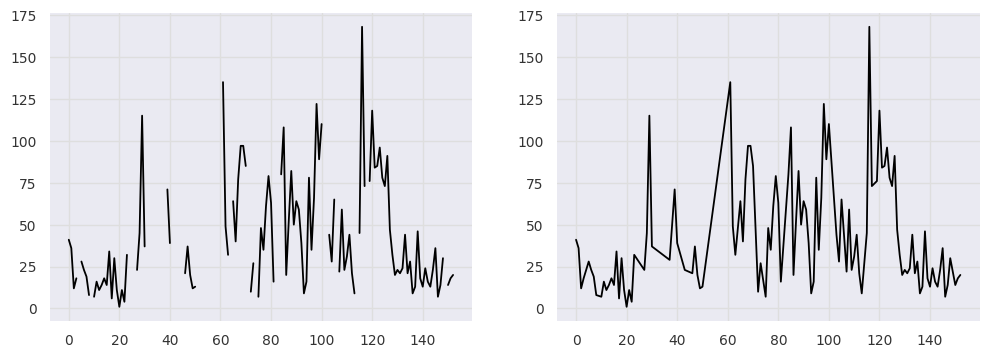

In [ ]:
#Display two plots side by side (before and after interpolation)
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
df['Ozone'].plot(ax=ax0)
df['Ozone'].interpolate().plot(ax=ax1)

NaN values are computed as follows: step_size = (max-min)/(#NaNs+1). For instance, (37-29)/(6+1) = 1.142857, which the increment starting from the smallest value 29.

In [ ]:
#Display two Pandas data frames side by side
df_joint = pd.concat([dfc, dfc.interpolate()], axis=1, join='inner')
df_joint.head(30)

,Date,Ozone,Temp,Date,Ozone,Temp
0,1976-05-01,41.0,67,1976-05-01,41.00,67
1,1976-05-02,36.0,72,1976-05-02,36.00,72
2,1976-05-03,12.0,74,1976-05-03,12.00,74
3,1976-05-04,18.0,62,1976-05-04,18.00,62
4,1976-05-05,NaN,56,1976-05-05,23.00,56
5,1976-05-06,28.0,66,1976-05-06,28.00,66
6,1976-05-07,23.0,65,1976-05-07,23.00,65
7,1976-05-08,19.0,59,1976-05-08,19.00,59
8,1976-05-09,8.0,61,1976-05-09,8.00,61
9,1976-05-10,NaN,69,1976-05-10,7.50,69


In [ ]:
dfc.head(6)

,Date,Ozone,Temp
0,1976-05-01,41.0,67
1,1976-05-02,36.0,72
2,1976-05-03,12.0,74
3,1976-05-04,18.0,62
4,1976-05-05,NaN,56
5,1976-05-06,28.0,66


In [ ]:
dfc.interpolate(method='spline', limit_direction='both', order=3).head(6)

,Date,Ozone,Temp
0,1976-05-01,41.00000,67
1,1976-05-02,36.00000,72
2,1976-05-03,12.00000,74
3,1976-05-04,18.00000,62
4,1976-05-05,26.14581,56
5,1976-05-06,28.00000,66


<Axes: >

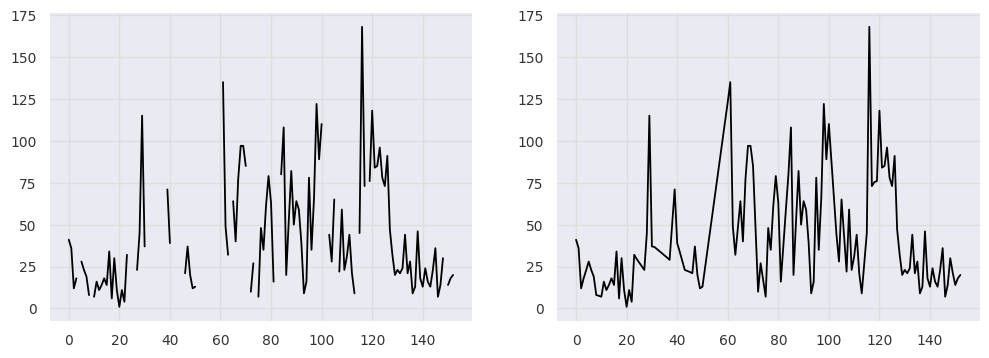

In [ ]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
df['Ozone'].plot(ax=ax0)
df['Ozone'].interpolate(method='spline', order=1).plot(ax=ax1)

**Basic Imputation techniques**

'ffill' or 'pad' - Replace NaN s with last observed value

'bfill' or 'backfill' - Replace NaN s with next observed value
Linear interpolation method

mean(), median(), and mode()

In [ ]:
df_temp_joint = pd.concat([df['Ozone'][31:50], df['Ozone'][31:50].fillna(dfc['Ozone'][31:50].median())], axis=1, join='inner')
df_temp_joint.head(30)

,Ozone,Ozone
31,NaN,26.0
32,NaN,26.0
33,NaN,26.0
34,NaN,26.0
35,NaN,26.0
36,NaN,26.0
37,29.0,29.0
38,NaN,26.0
39,71.0,71.0
40,39.0,39.0


In [ ]:
df_temp_joint = pd.concat([df['Ozone'][31:50], df['Ozone'][31:50].fillna(dfc['Ozone'][31:50].median())], axis=1, join='inner')
df_temp_joint.head(30)

,Ozone,Ozone
31,NaN,26.0
32,NaN,26.0
33,NaN,26.0
34,NaN,26.0
35,NaN,26.0
36,NaN,26.0
37,29.0,29.0
38,NaN,26.0
39,71.0,71.0
40,39.0,39.0


In [ ]:
df_temp_joint = pd.concat([df['Ozone'][31:50], df['Ozone'][31:50].interpolate(limit_direction="both",inplace=False)], axis=1, join='inner')
df_temp_joint.head(30)

,Ozone,Ozone
31,NaN,29.000000
32,NaN,29.000000
33,NaN,29.000000
34,NaN,29.000000
35,NaN,29.000000
36,NaN,29.000000
37,29.0,29.000000
38,NaN,50.000000
39,71.0,71.000000
40,39.0,39.000000


**Simple Imputation**

strategy = {‘mean’, ‘median’, ‘most_frequent’, ‘constant’}, default=’mean’

The imputation strategy.

If “mean”, then replace missing values using the mean along each column. Can only be used with numeric data.

If “median”, then replace missing values using the median along each column. Can only be used with numeric data.

If “most_frequent”, then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.

If “constant”, then replace missing values with fill_value. Can be used with strings or numeric data.

In [ ]:
from sklearn.impute import SimpleImputer

# Selecting the continous variables
cont_feats = ['Ozone', 'Solar', 'Wind', 'Temp']

# Simple Imputation: {‘mean’, ‘median’, ‘most_frequent’, ‘constant’}, default=’mean’
sim_imputer = SimpleImputer(strategy='median')
sim_imputed = sim_imputer.fit_transform(df[cont_feats])
df_sim_imputed = pd.DataFrame(sim_imputed, columns=cont_feats)

In [ ]:
df_simple_joint = pd.concat([df[cont_feats], df_sim_imputed], axis=1, join='inner')
df_simple_joint[31:50]

,Ozone,Solar,Wind,Temp,Ozone,Solar,Wind,Temp
31,NaN,286.0,8.6,78,31.5,286.0,8.6,78.0
32,NaN,287.0,9.7,74,31.5,287.0,9.7,74.0
33,NaN,242.0,16.1,67,31.5,242.0,16.1,67.0
34,NaN,186.0,9.2,84,31.5,186.0,9.2,84.0
35,NaN,220.0,8.6,85,31.5,220.0,8.6,85.0
36,NaN,264.0,14.3,79,31.5,264.0,14.3,79.0
37,29.0,127.0,9.7,82,29.0,127.0,9.7,82.0
38,NaN,273.0,6.9,87,31.5,273.0,6.9,87.0
39,71.0,291.0,13.8,90,71.0,291.0,13.8,90.0
40,39.0,323.0,11.5,87,39.0,323.0,11.5,87.0


**Iterative Imputation**

Multivariate imputer that estimates each feature from all the others.

estimator: default=BayesianRidge()

imputation_order{‘ascending’, ‘descending’, ‘roman’, ‘arabic’, ‘random’}, default=’ascending’
The order in which the features will be imputed. Possible values:

'ascending': From features with fewest missing values to most.

'descending': From features with most missing values to fewest.

'roman': Left to right.

'arabic': Right to left.

'random': A random order for each round.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Selecting the continous variables
cont_feats = ['Ozone', 'Solar', 'Wind', 'Temp']

mice_imputer = IterativeImputer()
mice_imputed = mice_imputer.fit_transform(df[cont_feats])
df_mice_imputed = pd.DataFrame(mice_imputed, columns=cont_feats)

df_mice_joint = pd.concat([df[cont_feats], df_mice_imputed], axis=1, join='inner')
df_mice_joint[31:50]

,Ozone,Solar,Wind,Temp,Ozone,Solar,Wind,Temp
31,NaN,286.0,8.6,78,52.256294,286.0,8.6,78.0
32,NaN,287.0,9.7,74,42.447883,287.0,9.7,74.0
33,NaN,242.0,16.1,67,9.692331,242.0,16.1,67.0
34,NaN,186.0,9.2,84,54.432740,186.0,9.2,84.0
35,NaN,220.0,8.6,85,59.949696,220.0,8.6,85.0
36,NaN,264.0,14.3,79,36.438940,264.0,14.3,79.0
37,29.0,127.0,9.7,82,29.000000,127.0,9.7,82.0
38,NaN,273.0,6.9,87,71.458923,273.0,6.9,87.0
39,71.0,291.0,13.8,90,71.000000,291.0,13.8,90.0
40,39.0,323.0,11.5,87,39.000000,323.0,11.5,87.0


In [ ]:
# Iterative Imputation
from sklearn.ensemble import RandomForestRegressor

iter_imputer = IterativeImputer(RandomForestRegressor(), max_iter=50)
iter_imputed = iter_imputer.fit_transform(df[cont_feats])
df_iter_imputed = pd.DataFrame(iter_imputed, columns=cont_feats)

df_iter_joint = pd.concat([df[cont_feats], df_iter_imputed], axis=1, join='inner')
df_iter_joint[31:50]

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



,Ozone,Solar,Wind,Temp,Ozone,Solar,Wind,Temp
31,NaN,286.0,8.6,78,38.99,286.0,8.6,78.0
32,NaN,287.0,9.7,74,18.60,287.0,9.7,74.0
33,NaN,242.0,16.1,67,21.39,242.0,16.1,67.0
34,NaN,186.0,9.2,84,50.18,186.0,9.2,84.0
35,NaN,220.0,8.6,85,80.25,220.0,8.6,85.0
36,NaN,264.0,14.3,79,33.47,264.0,14.3,79.0
37,29.0,127.0,9.7,82,29.00,127.0,9.7,82.0
38,NaN,273.0,6.9,87,67.07,273.0,6.9,87.0
39,71.0,291.0,13.8,90,71.00,291.0,13.8,90.0
40,39.0,323.0,11.5,87,39.00,323.0,11.5,87.0


**KNN imputation**

Imputation for completing missing values using k-Nearest Neighbors.

Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

n_neighbors: default=5

In [5]:
from sklearn.impute import KNNImputer

# Selecting the continous variables
cont_feats = ['Ozone', 'Solar', 'Wind', 'Temp']

knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
knn_imputed = knn_imputer.fit_transform(df[cont_feats])
df_knn_imputed = pd.DataFrame(knn_imputed, columns=cont_feats)

df_knn_joint = pd.concat([df[cont_feats], df_knn_imputed], axis=1, join='inner')
df_knn_joint[31:50]

,Ozone,Solar,Wind,Temp,Ozone,Solar,Wind,Temp
31,NaN,286.0,8.6,78,35.000000,286.0,8.6,78.0
32,NaN,287.0,9.7,74,18.333333,287.0,9.7,74.0
33,NaN,242.0,16.1,67,21.666667,242.0,16.1,67.0
34,NaN,186.0,9.2,84,64.000000,186.0,9.2,84.0
35,NaN,220.0,8.6,85,58.666667,220.0,8.6,85.0
36,NaN,264.0,14.3,79,17.333333,264.0,14.3,79.0
37,29.0,127.0,9.7,82,29.000000,127.0,9.7,82.0
38,NaN,273.0,6.9,87,54.333333,273.0,6.9,87.0
39,71.0,291.0,13.8,90,71.000000,291.0,13.8,90.0
40,39.0,323.0,11.5,87,39.000000,323.0,11.5,87.0


# **Darts TimeSeries**

**Read and Plot Time Series Data**

'the dataset has 153 data points'

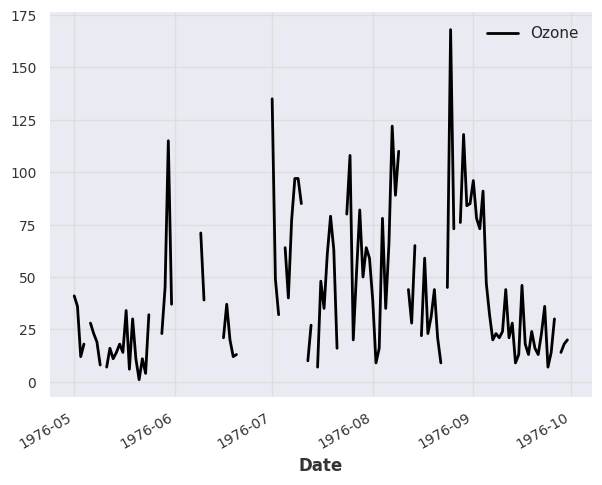

In [21]:
# create a Time Series object from the dataframe
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols='Ozone')
series.plot()
"the dataset has {} data points".format(len(series))

<Axes: xlabel='Date'>

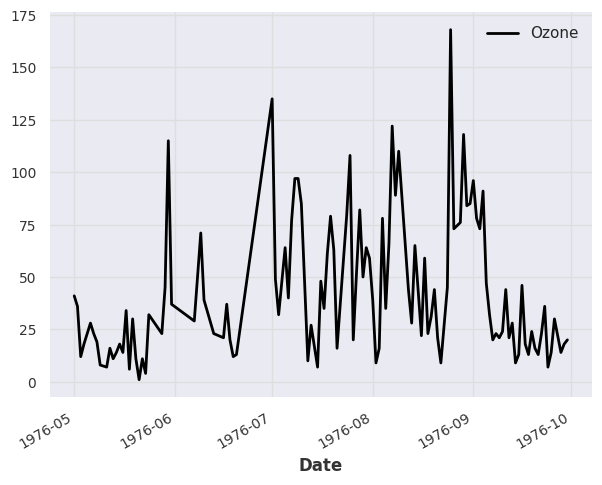

In [22]:
##pre-processing
from darts.utils.missing_values import fill_missing_values
series = fill_missing_values(series, fill='auto')
series.plot()

<Axes: xlabel='Date'>

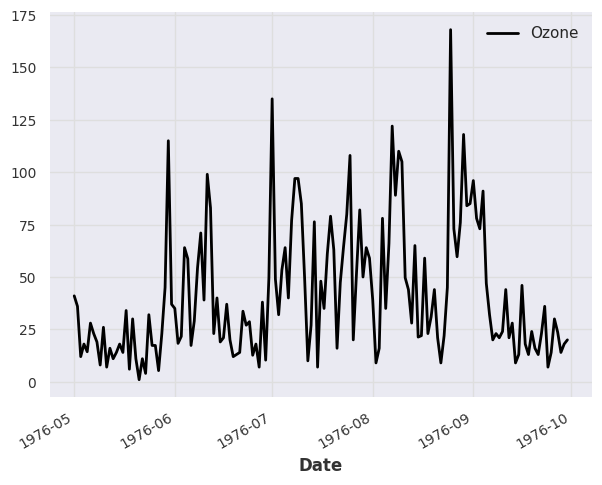

In [23]:
# create a Time Series object from the dataframe
df_new = pd.concat([df['Date'], df_knn_imputed], axis=1, join='inner')
series = TimeSeries.from_dataframe(df_new, time_col='Date', value_cols='Ozone')
series.plot()

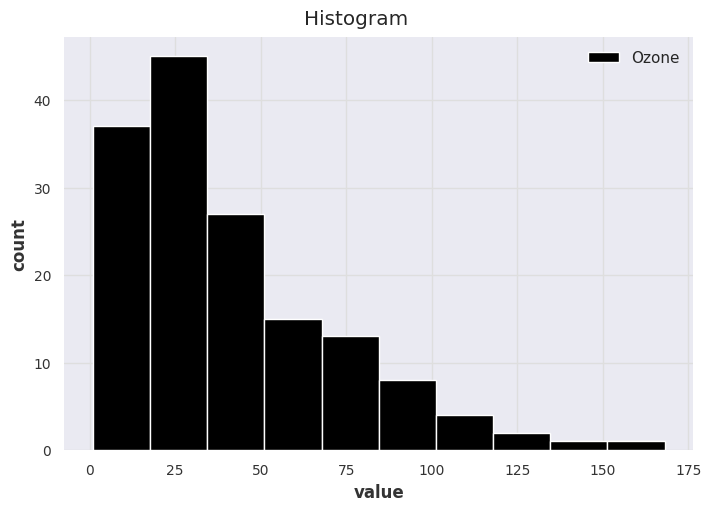

In [25]:
from darts.utils.statistics import plot_hist

#Plots the histogram of values in a TimeSeries
plot_hist(series)

**Autocorrelation Function (ACF)**

The ACF measures the correlation between a time series and its lagged values (i.e., observations with previous time steps). It helps to identify the presence of any repeating patterns or cycles in the data. A strong positive correlation at a specific lag indicates that the data is highly correlated with its past values at that lag, while a strong negative correlation indicates that the data is negatively correlated with its past values at that lag. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of -1 represents a perfect negative correlation. The ACF starts at a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

ACF (also called correlogram or an autocorrelation plot) helps identify seasonality in the time series data. The x-axis is lag in months, and y-axis is the correlation coefficient. Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

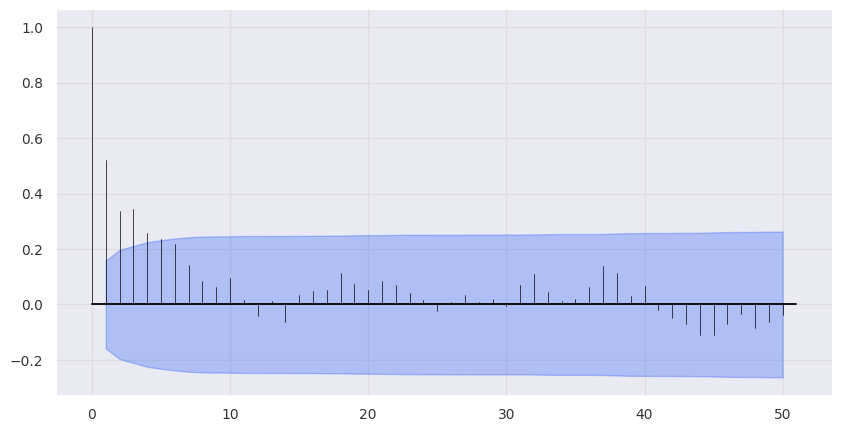

In [27]:
from darts.utils.statistics import plot_acf

#Plots the Autocorrelation Function (ACF) of ts (default: max_lag=24, alpha=0.05)
plot_acf(series, max_lag= 50)

23


'the resampled dataset has 23 data points'

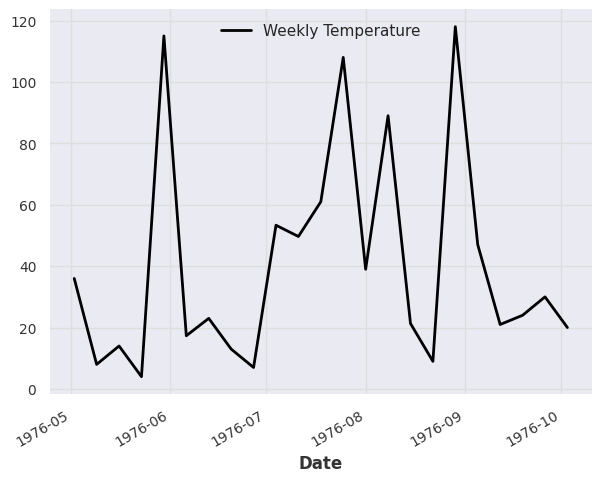

In [ ]:
#What if we want to plot our data on a weekly basis instead? We can just resample!
# Resampling and frequency conversion
resampled_series = series.resample("W")
resampled_series.plot(label="Weekly Temperature")
print(resampled_series.n_timesteps)
"the resampled dataset has {} data points".format(len(resampled_series))

**Preprocessing**

Usually neural networks tend to work better on normalised/standardised data. Here we’ll use the Scaler class to normalise both of our time series between 0 and 1:

"the 'daily temperature' dataset has 153 data points"

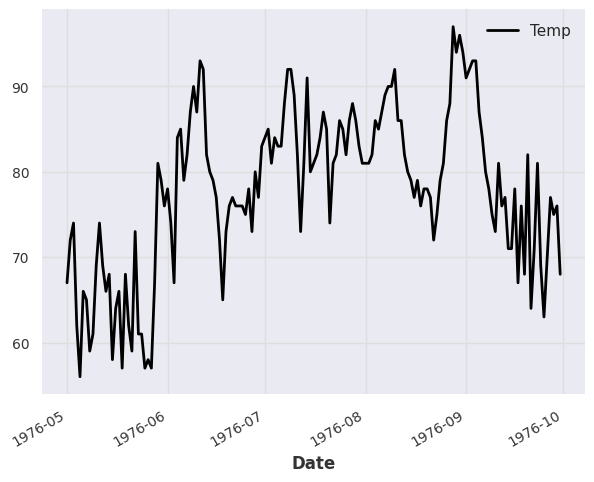

In [ ]:
# create a Time Series object from the dataframe
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols='Temp')
series.plot()
"the 'daily temperature' dataset has {} data points".format(len(series))

<Axes: xlabel='Date'>

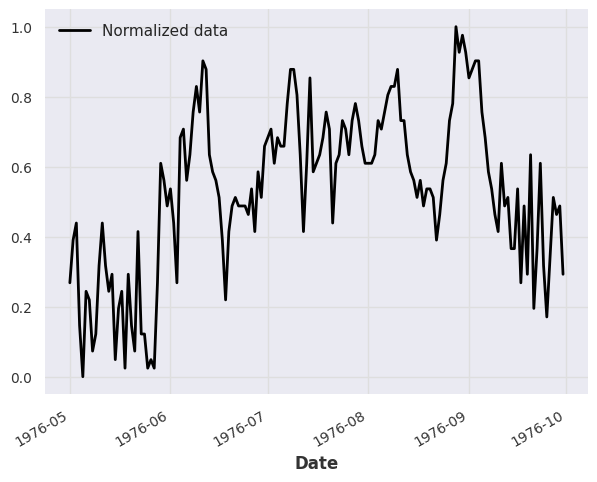

In [ ]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
series = scaler.fit_transform(series)

series.plot(label="Normalized data")

https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb

**Partition data into training and testing**

<Axes: xlabel='Date'>

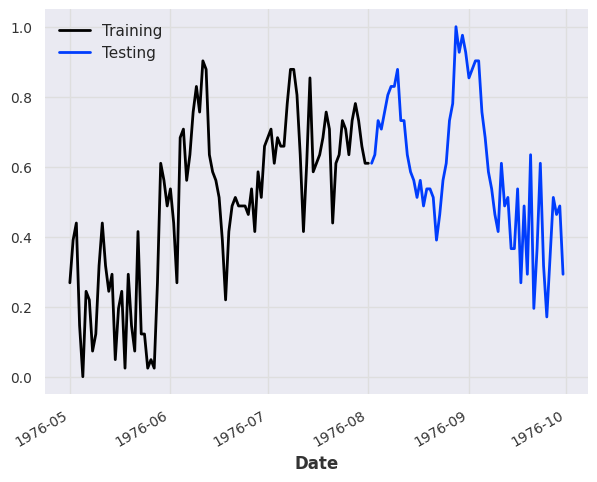

In [ ]:
# Set aside the last 60 days as a test series
train, test = series[:-60], series[-60:]
train.plot(label="Training")
test.plot(label="Testing")

**Another way to partition the data into training and testing**

In [ ]:
#test_size = 60/len(df)  #last 60 days
#train_size = 1-test_size
#train_size

<Axes: xlabel='Date'>

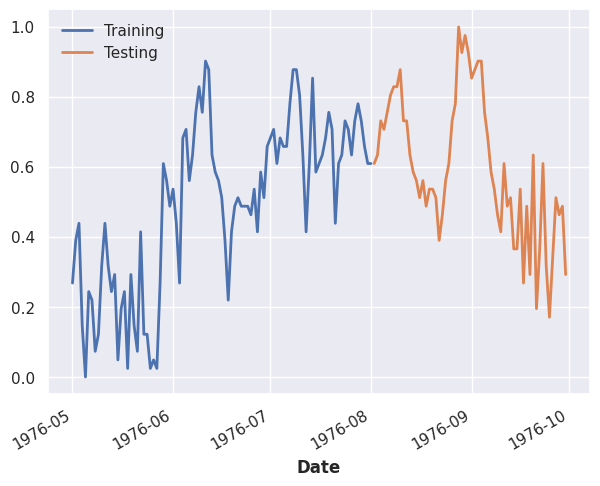

In [ ]:
from darts.utils.model_selection import train_test_split

train, test = train_test_split(series, test_size=60/len(df))
train.plot(label="Training")
test.plot(label="Testing")

In [ ]:
#create a training and test set
#train, test = series.split_before(pd.Timestamp(ts_input="19760801"))
#train, test = series.split_after(1-60/len(df))
#train.plot(label="Training")
#test.plot(label="Testing")

**Import Models**

In [ ]:
from darts.models import (
    ExponentialSmoothing,
    AutoARIMA,
    NaiveDrift,
    NaiveSeasonal,
    XGBModel,
    VARIMA,
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    NHiTSModel,
    TBATS,
    BlockRNNModel,
    Theta,
    DLinearModel,
    NLinearModel,
    TiDEModel,
)

<Axes: xlabel='Date'>

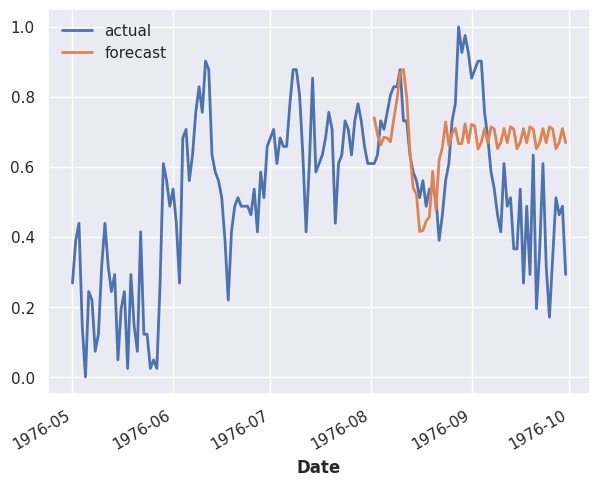

In [ ]:
model = XGBModel(lags=7, #  number of lagged target values used to predict the next time step
                 n_estimators=100, # number of trees in the model
                max_depth=6) # maximum depth of the tree - used to control overfitting, too deep and noise of the data will be learned

# fit the xgb model
model.fit(train)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

# plot the actual data
series.plot(label="actual")
# overlay the actual data with the predictions
pred.plot(label="forecast")

**Hyperparameter tuning (trying different lags values)**

<Axes: xlabel='Date'>

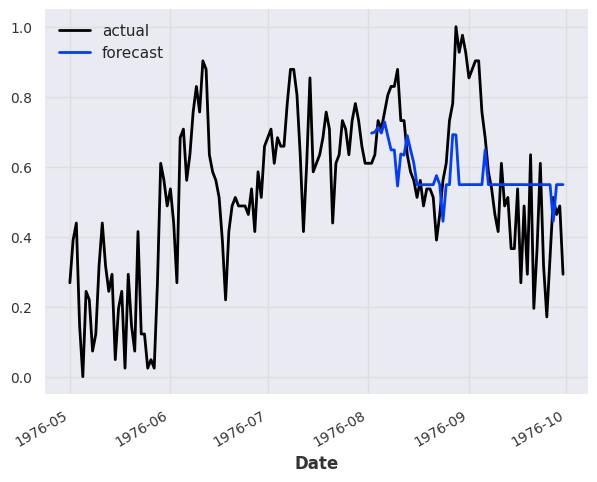

In [ ]:
from os import preadv
model = XGBModel(lags=80)

# fit the xgb model
model.fit(train)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

# plot the actual data
series.plot(label="actual")
# overlay the actual data with the predictions
pred.plot(label="forecast")

**D-Linear Model**

https://arxiv.org/pdf/2205.13504.pdf

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 210   
5 | linear_trend    | Linear           | 210   
-----------------------------------------------------
420       Trainable p

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


<Axes: xlabel='Date'>

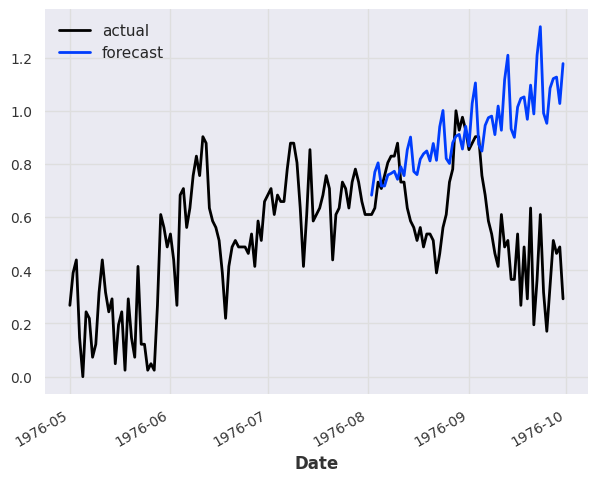

In [ ]:
model = DLinearModel(
    input_chunk_length=20,
    output_chunk_length=10,
    n_epochs=50,
    random_state=0,
    **generate_torch_kwargs()
)

# fit the model
model.fit(train)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

# plot the actual data
series.plot(label="actual")
# overlay the actual data with the predictions
pred.plot(label="forecast")

Let’s build an N-BEATS model that has a lookback window of 24 points (input_chunk_length=24) and predicts the next 12 points (output_chunk_length=12). We chose these values so it’ll make our model produce successive predictions for one year at a time, looking at the past two years.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


MAPE = 48.40%


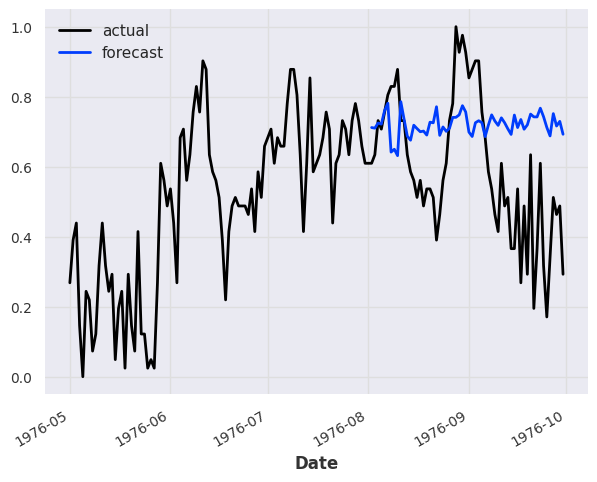

In [ ]:
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=50,
    random_state=0,
    **generate_torch_kwargs()
)

# fit the model
model.fit(train)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

series.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series, pred)))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


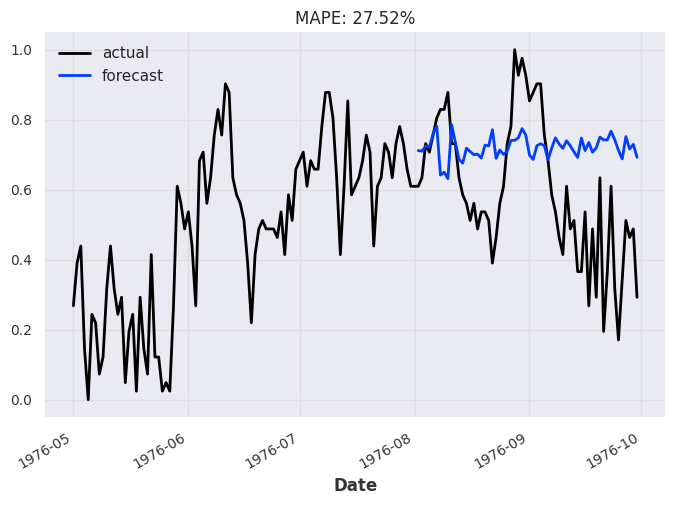

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8, 5))
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    plt.legend()


eval_model(model, 60, series, test)

**Transformer Model**

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 45.74%


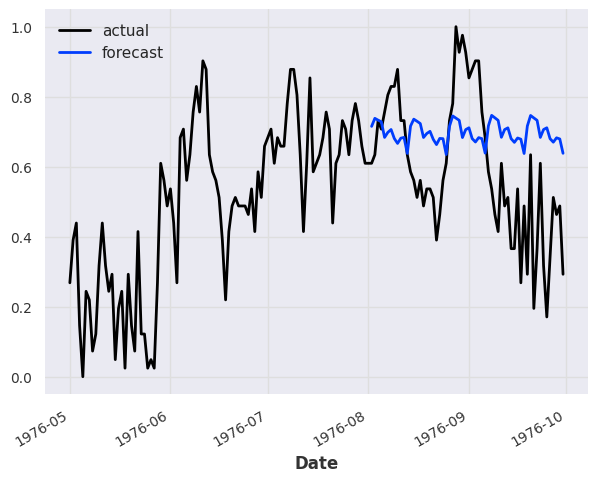

In [ ]:
model = TransformerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    batch_size=2,
    n_epochs= 50,
    model_name="Transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)

# fit the model
model.fit(series=train, val_series=test, verbose=True)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

series.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series, pred)))

**Time-series Dense Encoder**

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


MAPE = 45.43%


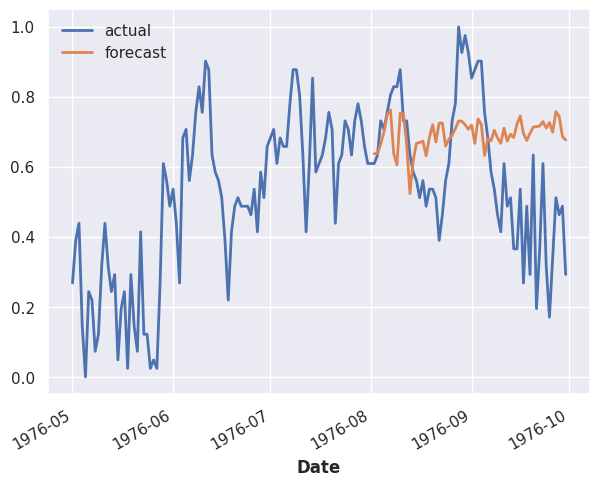

In [ ]:
from darts.models import TiDEModel

model = TiDEModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=50,
    random_state=0,
    **generate_torch_kwargs()
)

# fit the model
model.fit(train)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

# plot the actual data
series.plot(label="actual")
# overlay the actual data with the predictions
pred.plot(label="forecast")

plt.legend()
print("MAPE = {:.2f}%".format(mape(series, pred)))

**Prophet Model**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpft5f7icy/nbtzgkja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpft5f7icy/if_na1t0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82366', 'data', 'file=/tmp/tmpft5f7icy/nbtzgkja.json', 'init=/tmp/tmpft5f7icy/if_na1t0.json', 'output', 'file=/tmp/tmpft5f7icy/prophet_modeljeeeu2k_/prophet_model-20240218205006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

MAPE = nan%


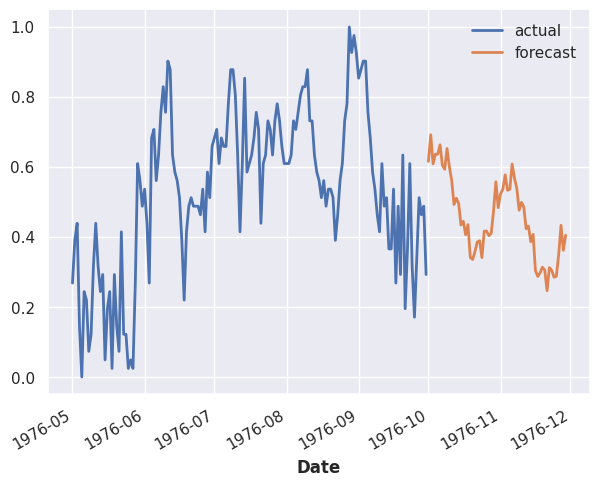

In [ ]:
from darts.models import Prophet
from darts.utils.timeseries_generation import datetime_attribute_timeseries
# optionally, use some future covariates; e.g. the value of the month encoded as a sine and cosine series
future_cov = datetime_attribute_timeseries(series, "day", cyclic=True, add_length=60)
# adding a seasonality (daily, weekly and yearly are included by default) and holidays
model = Prophet(
    add_seasonalities={
        'name':"quarterly_seasonality",
        'seasonal_periods':4,
        'fourier_order':5
        },
)
model.fit(series, future_covariates=future_cov)
pred = model.predict(n=60, future_covariates=future_cov)

# plot the actual data
series.plot(label="actual")
# overlay the actual data with the predictions
pred.plot(label="forecast")

plt.legend()
print("MAPE = {:.2f}%".format(mape(series, pred)))